# Purpose

The purpose of this notebook is to model the total miles driven in a day

In [1]:
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Notebook Last Run Initiated: 2018-04-05 09:39:04.717411


# Global Vars

In [2]:
inputdatadir = '/home/tgadf/astro_research_data/futuremiles/sparkData'
outdatadir   = '/home/tgadf/astro_research_data/futuremiles/modelData'
scoredatadir = '/home/tgadf/astro_research_data/futuremiles/modelData'
dataSuffix='20180402'
from timeUtils import getTimeSuffix
timeSuffix = getTimeSuffix()
timeSuffix='20180402'
n_jobs = 4
splitKey = None

extra='oldfeatures'
targetcol='total_miles'

useAnne=False
if useAnne is True:
    extra='oldfeaturesbyvin'
    targetcol='total_miles'
else:
    extra='newfeatures'
    targetcol='target'
    
    suffix='weekend'
    suffix="weekday"
    extra='newfeatures_{0}'.format(suffix)
    dataname='rolling_{0}'.format(suffix)
    
    #dataSuffix='20180331'
    suffix='newwindows_annedev'
    #suffix='oldwindows_annesdev'
    #suffix='newwindows_randomdev'
    extra='newfeatures_{0}'.format(suffix)
    dataname='rolling_{0}'.format(suffix)
    targetcol='target'
    
    #extra='anne_data'
    #dataname='anne_data'
    #targetcol='total_miles'

Current Time is Thu Apr 05, 2018 09:39:04 for Begin


# Module Imports

In [3]:

from numpy import reshape
from pandas import DataFrame, Series, to_datetime
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, SGDRegressor, BayesianRidge
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, MinMaxScaler, RobustScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.base import ClassifierMixin,RegressorMixin

from modelio import loadData, saveData, splitData, LoadOriginalData, splitDataByKey
from modelio import loadModel, saveModel
from modelio import savePredictData, splitFeaturesTarget

from timeUtils import clock, elapsed
from pandasUtils import cutDataFrameByDate, dropColumns, fillNAWithZero

from traintest import trainEstimator, predictEstimator, tuneEstimator

from transform import transformData

from pyearth import Earth

import sys
print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


# Load Data

In [4]:
from modelio import findPatternExt, loadJoblib
def loadDataPattern(name, outdir, dataSuffix, extra = None):
    basedir = '/home/tgadf/astro_research_data/pol_futuremiles_xgboost/train_test_files'
    pattern = pattern="_".join([name,dataSuffix])
    pattern = name
    files = findPatternExt(outdir, pattern=pattern, ext="p", debug=False)
    trainData = None
    for i,ifile in enumerate(files):
        print("Loading {0}/{1}: {2}".format(i+1,len(files),ifile), end='    ')
        if trainData is None:
            trainData = loadJoblib(ifile)
        else:
            trainData = trainData.append(loadJoblib(ifile))
        print(trainData.shape)
    return trainData

In [6]:
if useAnne:

    # If we need to reload the .csv
    start = clock("Getting Anne Data")
    data  = LoadOriginalData(pattern="_27_nogps", extra=extra, dropcols=False, fillna=True, savedata=False)
    elapsed(start, comment="Loaded Anne Data")
    splitKey = 'dev_imei'
    dropColumns(data, ['Unnamed: 0', 'this_date_min_1hr_segment'])
    data['date'] = to_datetime(data['date'])
    data.index = data['date']
    data = cutDataFrameByDate(data, mindate='2017-04-01')
    fillNAWithZero(data)
    dropColumns(data, 'date')
    elapsed(start, comment="Formatting DataFrame")    
else:
    start = clock("Getting Rolling Data")
    data  = loadDataPattern(name=dataname, outdir=inputdatadir, dataSuffix=dataSuffix, extra=None)
    elapsed(start, comment="Loaded Rolling Data")
    splitKey = 'dev_imei'

    start = clock("Formatting DataFrame")
    data['date'] = to_datetime(data['date'])
    data.index = data['date']
    #data = cutDataFrameByDate(data, mindate='2017-04-01')
    fillNAWithZero(data)
    dropColumns(data, ['date'])
    elapsed(start, comment="Formatting DataFrame")

Current Time is Thu Apr 05, 2018 09:40:06 for Getting Rolling Data
Loading 1/6: /home/tgadf/astro_research_data/futuremiles/sparkData/rolling_newwindows_annedev_1_nogps-2017-04-02.p    (396000, 257)
Loading 2/6: /home/tgadf/astro_research_data/futuremiles/sparkData/rolling_newwindows_annedev_5_nogps-2017-04-02.p    (792000, 257)
Loading 3/6: /home/tgadf/astro_research_data/futuremiles/sparkData/rolling_newwindows_annedev_2_nogps-2017-04-02.p    (1188000, 257)
Loading 4/6: /home/tgadf/astro_research_data/futuremiles/sparkData/rolling_newwindows_annedev_3_nogps-2017-04-02.p    (1584000, 257)
Loading 5/6: /home/tgadf/astro_research_data/futuremiles/sparkData/rolling_newwindows_annedev_4_nogps-2017-04-02.p    (1980000, 257)
Loading 6/6: /home/tgadf/astro_research_data/futuremiles/sparkData/rolling_newwindows_annedev_6_nogps-2017-04-02.p    (2376000, 257)
Current Time is Thu Apr 05, 2018 09:41:49 for Loaded Rolling Data
Process [Loaded Rolling Data] took 1.7 minutes.
Current Time is Thu Apr

In [7]:

def splitDataByKey(pddata, key, targetcol, trainFraction=0.25):
    """
    Split the data into test and train data
    
    Inputs:
      > pddata: the model feature data (DataFrame)
      > key: a key to split the train/test data on
      > targetcol: the name of the target column
      > trainFraction (0.25 by default): fraction of events to use for training
      
    Outputs:
      > Training feature data (DataFrame), Testing feature data (DataFrame), Training target data (Series), Testing target data (Series)
    """
    keydata = [str(x) for x in list(pddata[key].unique())]
    print("There are {0} unique keys.".format(len(keydata)))
    print("Using {0} training fraction.".format(trainFraction))
    from random import sample
    from numpy import asarray
    trainKeys = list(sample(keydata, int(trainFraction*len(keydata))))
    testKeys = [e for e in keydata if e not in trainKeys]
    
    if len(set(trainKeys).intersection(testKeys)) > 0:
        print("There are common keys in train/test!!")
        return None
    
    trainKeys = asarray(trainKeys)
    testKeys  = asarray(testKeys)
    print("There are {0} keys in the training data.".format(trainKeys.shape[0]))
    print("There are {0} keys in the testing data.".format(testKeys.shape[0]))
        
    trainData = pddata[pddata[key].isin(trainKeys)].copy()
    testData  = pddata[pddata[key].isin(testKeys)].copy()
    
    return trainData

In [22]:
trainData = splitDataByKey(data, key=splitKey, targetcol=targetcol, trainFraction=0.25)
trainData = cutDataFrameByDate(trainData, maxdate='2017-12-31')


There are 6000 unique keys.
Using 0.25 training fraction.
There are 1500 keys in the training data.
There are 4500 keys in the testing data.


In [34]:
testTarget1 = trainData[trainData['dev_imei'] == '352252067000753']['target']
testTarget2 = trainData[trainData['dev_imei'] == '354235052996687']['target']
testTarget2

date
2017-01-02     5.4
2017-01-09     0.0
2017-01-16     0.0
2017-01-23    14.2
2017-01-30    15.3
2017-02-06     1.8
2017-02-13    14.1
2017-02-20     0.0
2017-02-27     7.6
2017-03-06     5.5
2017-03-13    17.1
2017-03-20    14.2
2017-03-27     7.6
2017-04-03     1.6
2017-04-10    16.1
2017-04-17    20.6
2017-04-24    14.3
2017-05-01    18.5
2017-05-08     0.0
2017-05-15    14.2
2017-05-22    15.3
2017-05-29     1.4
2017-06-05    17.2
2017-06-12    14.2
2017-06-19    14.3
2017-06-26    20.5
2017-07-03    16.8
2017-07-10    14.1
2017-07-17    27.1
2017-07-24    14.4
              ... 
2017-06-11     6.4
2017-06-18    10.3
2017-06-25     0.0
2017-07-02     0.0
2017-07-09    11.1
2017-07-16     1.4
2017-07-23     0.0
2017-07-30     1.4
2017-08-06     0.0
2017-08-13    36.1
2017-08-20     7.1
2017-08-27    30.2
2017-09-03     4.1
2017-09-10    35.1
2017-09-17    27.9
2017-09-24     4.0
2017-10-01     4.0
2017-10-08     0.0
2017-10-15     5.5
2017-10-22     4.0
2017-10-29    98.6
2017-11

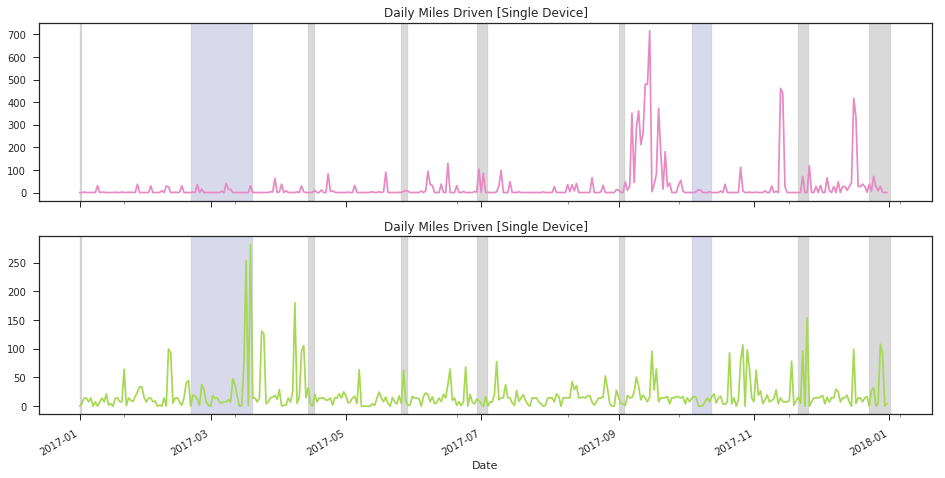

In [41]:
def plotHoliday(ax):
    from numpy import ndarray
    breaks = getBreaks()
    holidays = getHolidays()
    
    for holiday in breaks:
        if isinstance(ax,list):
            for i in range(len(ax)):
                ax[i].axvspan(holiday[0], holiday[1], alpha=0.15, color='navy')
        elif isinstance(ax,ndarray):
            if ax.ndim == 1:
                for i in range(len(ax)):
                    ax[i].axvspan(holiday[0], holiday[1], alpha=0.15, color='navy')
            if ax.ndim == 2:
                for i in range(len(ax)):
                    for j in range(len(ax[i])):
                        ax[i,j].axvspan(holiday[0], holiday[1], alpha=0.15, color='navy')
        else:
            ax.axvspan(holiday[0], holiday[1], alpha=0.15, color='navy')    
            
    for holiday in holidays:
        if isinstance(ax,list):
            for i in range(len(ax)):
                ax[i].axvspan(holiday[0], holiday[1], alpha=0.15, color='black')
        elif isinstance(ax,ndarray):
            if ax.ndim == 1:
                for i in range(len(ax)):
                    ax[i].axvspan(holiday[0], holiday[1], alpha=0.15, color='black')
            if ax.ndim == 2:
                for i in range(len(ax)):
                    for j in range(len(ax[i])):
                        ax[i,j].axvspan(holiday[0], holiday[1], alpha=0.15, color='black')
        else:
            ax.axvspan(holiday[0], holiday[1], alpha=0.15, color='black')

import seaborn as sns
from matplotlib import pyplot as plt
cols = sns.color_palette("Set2", 5)
sns.set(style="ticks")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)
testTarget1.plot(color=cols[3], label='Series', ax=axes[0])
axes[0].set_xlabel('Date')
axes[0].set_title('Daily Miles Driven [Single Device]')
testTarget2.plot(color=cols[4], label='Series', ax=axes[1])
axes[1].set_xlabel('Date')
axes[1].set_title('Daily Miles Driven [Single Device]')

from tsUtils import getBreaks, getHolidays
plotHoliday(axes)

In [5]:
if useAnne:
    devs = data['dev_imei'].unique().tolist()
    import json
    json.dump(devs, open("annedevs.json", "w"))

# Split Features and Target and Test/Train

In [35]:
start = clock("Creating Test/Train Datasets Using SplitKey {0}".format(splitKey))

if splitKey is not None:
    ## If we're splitting on a key
    X_train, X_test, y_train, y_test = splitDataByKey(data, key=splitKey, targetcol=targetcol, trainFraction=0.25)
    featureNames = X_train.columns
    transformers={"X": None, "y": None}
else:
    ## If we're randomly splitting
    features, target = splitFeaturesTarget(data, targetcol)

    ## Transform (if needed)
    retval   = transformData(extra, features, target)
    features = retval['X_data']
    target   = retval['y_data']
    X_scaler = retval['X_scaler']
    y_scaler = retval['y_scaler']

    ## Split test/train
    print("Spliting test and train data")
    X_train, X_test, y_train, y_test = splitData(features, target, trainFraction=0.33)
    featureNames = X_train.columns
    transformers={"X": X_scaler, "y": y_scaler}
    
## Save everything
data = {"testDataX": X_test, "testDataY": y_test, "trainDataX": X_train, "trainDataY": y_train, 
        "transformers": transformers, "features": featureNames}
for name,value in data.items():
    saveData(value, name=name, outdir=outdatadir, dataSuffix=dataSuffix, extra=extra)

elapsed(start, comment="Created Test/Train Datasets")

Current Time is Tue Apr 03, 2018 14:04:40 for Creating Test/Train Datasets Using SplitKey dev_imei
There are 6000 unique keys.
Using 0.25 training fraction.
There are 1500 keys in the training data.
There are 4500 keys in the testing data.
Train data has size (459000, 255) with target size (459000,).
Test data has size (1377000, 255) with target size (1377000,).
Saving testDataX data to /home/tgadf/astro_research_data/futuremiles/modelData/testDataX-20180402-newfeatures_newwindows_annedev.p
  --> This file is 969.7MB.
Saving testDataY data to /home/tgadf/astro_research_data/futuremiles/modelData/testDataY-20180402-newfeatures_newwindows_annedev.p
  --> This file is 5.3MB.
Saving trainDataX data to /home/tgadf/astro_research_data/futuremiles/modelData/trainDataX-20180402-newfeatures_newwindows_annedev.p
  --> This file is 328.0MB.
Saving trainDataY data to /home/tgadf/astro_research_data/futuremiles/modelData/trainDataY-20180402-newfeatures_newwindows_annedev.p
  --> This file is 1.8MB.

In [6]:
featureNames

Index(['weekday', 'holiday', 'notrips_lag1days', 'trips_avg_lag1days',
       'trips_am_avg_lag1days', 'trips_pm_avg_lag1days',
       'trips_early_avg_lag1days', 'trips_late_avg_lag1days',
       'trips_asym_avg_lag1days', 'miles_sum_avg_lag1days',
       ...
       'duration_high_ratio_avg_lag10days_dow',
       'duration_high_frac_avg_lag10days_dow', 'speed_max_avg_lag10days_dow',
       'speed_high_cnt_avg_lag10days_dow', 'speed_high_frac_avg_lag10days_dow',
       'speed_mid_cnt_avg_lag10days_dow', 'time_away_avg_lag10days_dow',
       'time_firsttrip_avg_lag10days_dow', 'time_lasttrip_avg_lag10days_dow',
       'accel_sum_avg_lag10days_dow'],
      dtype='object', length=263)

In [36]:
## Init Models
models = {}

In [12]:
def trainXGBoost(name, X_train, y_train):
    name = 'xgboost'
    start = clock("Training {0}".format(name))
    xgb = xgboost.XGBRegressor(n_jobs=2)
    config = {'njobs': 2, 'grid': {'min_child_weight': [500], 'max_depth': [8], 'learning_rate': [0.1], 'gamma': [0.3]}}

    tune = True
    if tune is True:
        tuneResults = tuneEstimator(name, xgb, X_train, y_train, config, debug=True)
        model = tuneResults['estimator']
    else:
        params = {'min_child_weight': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3}
        xgb.set_params(**params)
        model = trainEstimator(name, xgb, X_train, y_train)    
    elapsed(start, comment="Trained {0}".format(name))
    return model

In [13]:
def trainLinReg(name, X_train, y_train):
    name = 'linreg'
    start = clock("Training {0}".format(name))
    glm = LinearRegression()
    model = trainEstimator(name, glm, X_train, y_train)
    elapsed(start, comment="Trained {0}".format(name))
    return model

# Train xgboost

In [37]:
models={}
models['linreg'] = trainLinReg("linreg", X_train, y_train)

Current Time is Tue Apr 03, 2018 14:09:11 for Training linreg
Current Time is Tue Apr 03, 2018 14:09:19 for Trained linreg
Process [Trained linreg] took 7.0 seconds.


In [27]:
models={}
models['linreg_10k_50'] = trainLinReg("linreg_anne", X_train, y_train)

Current Time is Mon Apr 02, 2018 10:31:45 for Training linreg
Current Time is Mon Apr 02, 2018 10:32:16 for Trained linreg
Process [Trained linreg] took 30.0 seconds.


In [ ]:
models['xgboost'] = trainXGBoost("xgboost", X_train, y_train)

In [ ]:
models['xgboost_meold'] = trainXGBoost("xgboost_meold", X_train, y_train)

In [26]:
models['xgboost_10k_10'] = trainXGBoost("xgboost_10k", X_train, y_train)

Current Time is Mon Apr 02, 2018 11:37:58 for Training xgboost
Tuning a xgboost estimator
Running random parameter search
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  4.1min finished


Tested 1 Parameter Sets
CV Fit Time Info (Mean,Std): (235.0 , 0.0)
Best Score                 : 0.185
Worst Score                : 0.185
CV Test Scores (Mean,Std)  : (0.2 , 0.0)
Best Parameters
Param: min_child_weight = 500
Param: max_depth = 8
Param: learning_rate = 0.1
Param: gamma = 0.3
Current Time is Mon Apr 02, 2018 11:50:55 for Trained xgboost
Process [Trained xgboost] took 12.9 minutes.


In [11]:
name = 'xgboost_me'
start = clock("Training {0}".format(name))
xgb = xgboost.XGBRegressor(n_jobs=2)
config = {'njobs': 6, 'grid': {'min_child_weight': [100, 500], 'max_depth': [3, 6, 10], 'learning_rate': [0.1], 'gamma': [0.3]}}

tune = True
if tune is True:
    best = tuneEstimator(name, xgb, X_train, y_train, config, debug=True)
    models[name] = best['estimator']
else:
    xgb.set_params(**params)
    models[name] = trainEstimator(name, xgb, X_train, y_train)
elapsed(start, comment="Trained {0}".format(name))

Current Time is Sun Apr 01, 2018 16:44:32 for Training xgboost_me
Tuning a xgboost_me estimator
Running random parameter search
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed: 40.7min finished


Tested 9 Parameter Sets
CV Fit Time Info (Mean,Std): (394.4 , 173.3)
Best Score                 : 0.329
Worst Score                : 0.324
CV Test Scores (Mean,Std)  : (0.3 , 0.0)
Best Parameters
Param: min_child_weight = 500
Param: max_depth = 6
Param: learning_rate = 0.1
Param: gamma = 0.3
Current Time is Sun Apr 01, 2018 17:37:54 for Trained xgboost_me
Process [Trained xgboost_me] took 53.4 minutes.


In [25]:
name = 'xgboost_anne'
start = clock("Training {0}".format(name))
xgb = xgboost.XGBRegressor(n_jobs=2)
config = {'njobs': 6, 'grid': {'min_child_weight': [50, 100, 500], 'max_depth': [3, 6, 10], 'learning_rate': [0.1], 'gamma': [0.3]}}

best = tuneEstimator(name, xgb, X_train, y_train, config, debug=True)
#xgb.set_params(**params)
#models[name] = trainEstimator(name, xgb, X_train, y_train)
#print(type(xgb))
models[name] = best['estimator']
elapsed(start, comment="Trained {0}".format(name))

Current Time is Sun Apr 01, 2018 17:45:02 for Training xgboost_anne
Tuning a xgboost_anne estimator
Running random parameter search
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=6)]: Done  18 out of  18 | elapsed:  4.7min finished


Tested 9 Parameter Sets
CV Fit Time Info (Mean,Std): (85.4 , 38.6)
Best Score                 : 0.218
Worst Score                : 0.211
CV Test Scores (Mean,Std)  : (0.2 , 0.0)
Best Parameters
Param: min_child_weight = 500
Param: max_depth = 10
Param: learning_rate = 0.1
Param: gamma = 0.3
Current Time is Sun Apr 01, 2018 17:53:47 for Trained xgboost_anne
Process [Trained xgboost_anne] took 8.7 minutes.


# Train linear regression

Current Time is Sun Apr 01, 2018 17:53:47 for Training linreg_anne
Current Time is Sun Apr 01, 2018 17:53:49 for Trained linreg_anne
Process [Trained linreg_anne] took 1.0 seconds.


In [27]:
del models['linreg_me']
del models['xgboost_me']

# Save Model

In [38]:
start = clock(comment="Saving Models")

for k,v in models.items():
    saveModel(estimator=v, name=k, outdir=outdatadir, dataSuffix=dataSuffix, timeSuffix=timeSuffix, extra=extra)

elapsed(start, comment="Saved Models")

Current Time is Tue Apr 03, 2018 14:10:29 for Saving Models
Saving linreg model to /home/tgadf/astro_research_data/futuremiles/modelData/linreg-20180402-20180402-newfeatures_newwindows_annedev.p
  --> This file is 4.4kB.
Current Time is Tue Apr 03, 2018 14:10:29 for Saved Models
Process [Saved Models] took 0.0 seconds.


# Predict Model

In [39]:
start = clock(comment="Predict Model Response")

train = {}
test  = {}
for name,estimator in models.items():
    print("  Predicting {0}".format(name))
    
    prediction = predictEstimator(name, estimator, X_test, y_test)
    savePredictData(prediction, name=name, outdir=scoredatadir, dataSuffix=dataSuffix, timeSuffix=timeSuffix, extra=extra)

elapsed(start, comment="Predicted Model Response")

Current Time is Tue Apr 03, 2018 14:10:29 for Predict Model Response
  Predicting linreg
Saving linreg predict data to /home/tgadf/astro_research_data/futuremiles/modelData/linreg-predict-20180402-20180402-newfeatures_newwindows_annedev.p
  --> This file is 18.3MB.
Current Time is Tue Apr 03, 2018 14:10:33 for Predicted Model Response
Process [Predicted Model Response] took 4.0 seconds.


In [31]:
models['xgboost_10k_10'] = models['xgboost_10k_10']['estimator']